In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [8]:
ticker = 'SPY'
data = yf.download(ticker, start='2010-01-01', end='2023-12-31', auto_adjust= False)
print("Raw data shape:", data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed

Raw data shape: (3522, 6)


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
2010-01-04,86.026459,113.330002,113.389999,111.510002,112.370003,118944600
2010-01-05,86.254166,113.629997,113.680000,112.849998,113.260002,111579900
2010-01-06,86.314911,113.709999,113.989998,113.430000,113.519997,116074400
2010-01-07,86.679268,114.190002,114.330002,113.180000,113.500000,131091100
2010-01-08,86.967712,114.570000,114.620003,113.660004,113.889999,126402800


In [13]:
data['SMA_10'] = data['Adj Close', 'SPY'].rolling(window=10).mean()
data['SMA_50'] = data['Adj Close', 'SPY'].rolling(window=50).mean()

# 10-day Exponential Moving Average (EMA)
data['EMA_10'] = data['Adj Close', 'SPY'].ewm(span=10, adjust=False).mean()

# Function to compute the 14-day RSI
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = compute_RSI(data['Adj Close', 'SPY'], period=14)

# Create a 'Target' column for the next day's adjusted close price
data['Target'] = data['Adj Close', 'SPY'].shift(-1)

# Drop rows with missing values (due to moving averages, RSI, and shifting)
data.dropna(inplace=True)
print("Data shape after adding indicators and dropping NA:", data.shape)
data.head(10)

Data shape after adding indicators and dropping NA: (3422, 11)


Price,Adj Close,Close,High,Low,Open,Volume,SMA_10,SMA_50,EMA_10,RSI,Target
Ticker,SPY,SPY,SPY,SPY,SPY,SPY,,,,,
Date,,,,,,,,,,,
2010-05-25,82.180962,107.820000,107.870003,104.379997,105.110001,396505200,85.185573,89.118892,84.540596,32.366668,81.685532
2010-05-26,81.685532,107.169998,109.470001,106.849998,108.480003,349719300,84.402029,88.985315,84.021494,37.056838,84.421852
2010-05-27,84.421852,110.760002,110.800003,108.779999,109.190002,300870500,84.003396,88.895988,84.094286,48.966952,83.362389
2010-05-28,83.362389,109.370003,110.720001,108.849998,110.639999,297933500,83.658879,88.786383,83.961214,33.591051,81.959938
2010-06-01,81.959938,107.529999,109.949997,107.370003,108.349998,277909400,83.169548,88.657723,83.597346,31.306203,84.094093
2010-06-02,84.094093,110.330002,110.339996,107.510002,108.080002,240243700,83.011771,88.562295,83.687663,34.773279,84.383751
2010-06-03,84.383751,110.709999,111.059998,109.580002,110.650002,226618300,82.931741,88.460160,83.814225,38.161435,81.418755
2010-06-04,81.418755,106.820000,109.330002,106.459999,108.610001,398475600,82.876860,88.307413,83.378685,35.325804,80.405037


In [14]:
# 3. Prepare Dataset for RNN
# -------------------------------
# Select feature columns that will be used by the model.
features = ['Adj Close', 'Volume', 'SMA_10', 'SMA_50', 'EMA_10', 'RSI']
# Extract features and target from the DataFrame.
feature_data = data[features].values
target_data = data['Target'].values

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(feature_data)
target = data['Target'].values.reshape(-1, 1)
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target)

In [24]:
window_size = 60
X, y = [], []
for i in range(window_size, len(scaled_features)):
    X.append(scaled_features[i-window_size:i])
    y.append(target_data[i])
X, y = np.array(X), np.array(y)

In [25]:
split_fraction = 0.8
train_size = int(len(X) * split_fraction)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (2689, 60, 6) (2689,)
Testing data shape: (673, 60, 6) (673,)


c:\Users\pacey\anaconda3\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)            │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 50)             │        18,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,651 (80.67 KB)

 Trainable params: 20,651 (80.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 40080.1953 - val_loss: 150041.4219
Epoch 2/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 36102.1680 - val_loss: 120874.2344
Epoch 3/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 27753.9023 - val_loss: 77921.3125
Epoch 4/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16793.5801 - val_loss: 30073.6406
Epoch 5/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5910.1689 - val_loss: 1863.1475
Epoch 6/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1109.6300 - val_loss: 1675.7593
Epoch 7/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1212.9016 - val_loss: 656.3625
Epoch 8/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 930.4120 - val_loss: 292.4938
Epoch 9/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1028.7303 - val_loss: 262.4600
Epoch 10/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 964.6462 - val_loss: 305.3917
Epoch 11/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 878.1292 - val_loss: 282.

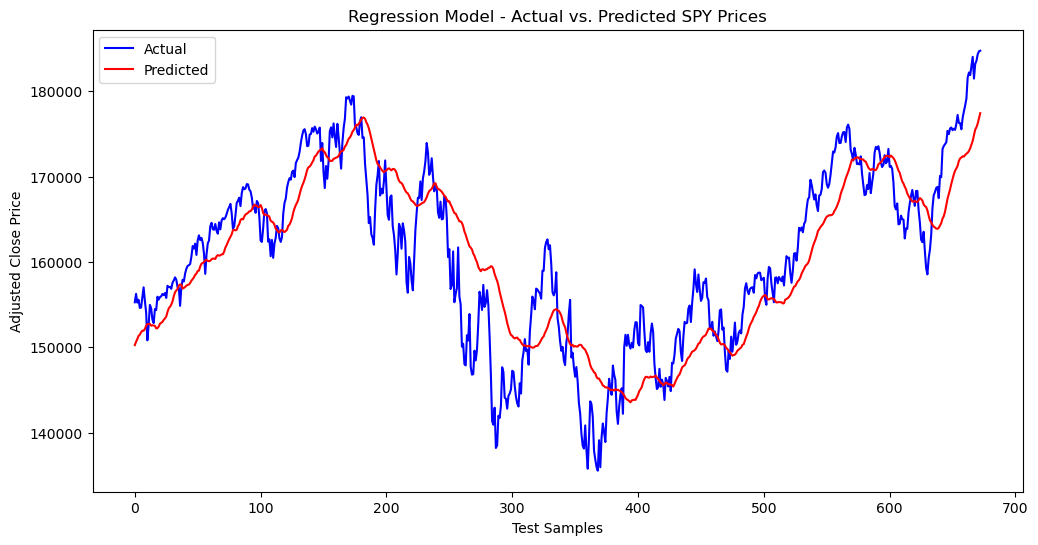

In [44]:
model = Sequential()
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
model.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

# Hidden layer 1
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.2))

# Hidden layer 2
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# -------------------------------
# 6. Train the Model
# -------------------------------
history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=220,
    validation_data=(X_test, y_test)
)

# -------------------------------
# 7. Evaluate & Plot Predictions
# -------------------------------
# Predict on test set (scaled)
y_pred_scaled = model.predict(X_test)

# Invert the scaling to compare with real prices
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_2d = y_test.reshape(-1, 1)
y_actual = target_scaler.inverse_transform(y_test_2d)

# Flatten for plotting
y_pred = y_pred.ravel()
y_actual = y_actual.ravel()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.xlabel('Test Samples')
plt.ylabel('Adjusted Close Price')
plt.title('Regression Model - Actual vs. Predicted SPY Prices')
plt.legend()
plt.show()


In [45]:
from sklearn.metrics import r2_score, mean_absolute_error

# Assume y_actual and y_pred are your unscaled target values (1D arrays)
r2 = r2_score(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)

print("R^2 Score:", r2)
print("Mean Absolute Error (MAE):", mae)


R^2 Score: 0.7311592741540871
Mean Absolute Error (MAE): 4311.247117592041


In [26]:
model = Sequential()
# First LSTM layer with dropout regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
# Dense output layer to predict the next day's adjusted close price
model.add(Dense(1))

# Compile the model with mean squared error loss and the Adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Users\pacey\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# -------------------------------
# 7. Evaluate the Model
# -------------------------------
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


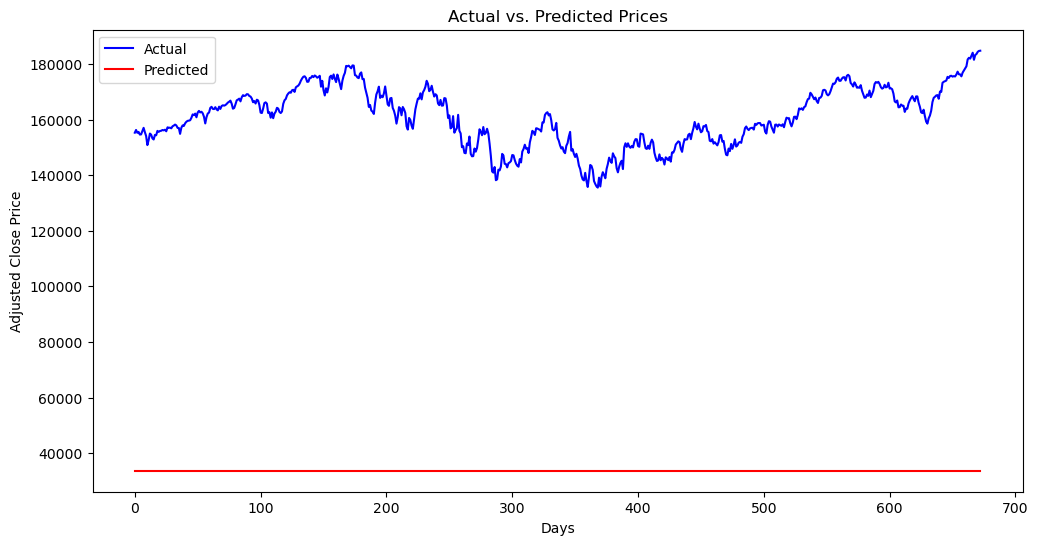

In [29]:
# 1. Get scaled predictions
y_pred_scaled = model.predict(X_test)

# 2. Invert scaling for predictions
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_pred = y_pred.ravel()  # Convert from shape (n,1) to (n,)

# 3. Invert scaling for actual test values
y_test_2d = y_test.reshape(-1, 1)
y_actual = target_scaler.inverse_transform(y_test_2d)
y_actual = y_actual.ravel()

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.xlabel('Days')
plt.ylabel('Adjusted Close Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.show()


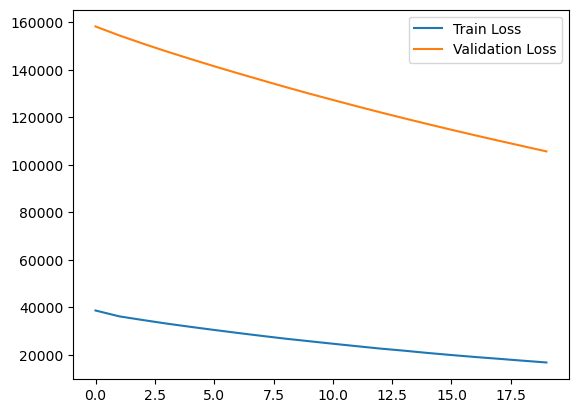

In [31]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()